In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
%matplotlib inline
pd.options.mode.chained_assignment = None

# Load the avalanche data into a dataframe and clean it

In [2]:
avalanches_df = pd.read_csv('CAIC_avalanches.csv')
avalanches_df = avalanches_df[["Date", "BC Zone", "Asp", "Type", "Trigger", "Rsize", "Dsize", "Area Description", "Comments"]]
avalanches_df.fillna(value = {"Date": pd.NA, "BC Zone": pd.NA, "Asp": pd.NA, "Type": pd.NA, "Trigger": pd.NA, "Area Description": "", "Comments": ""}, inplace = True)
avalanches_df["Description"], avalanches_df["Zone"], avalanches_df["Aspect"] = avalanches_df[["Area Description", "Comments"]].agg('\n'.join, axis=1).str.strip(), avalanches_df["BC Zone"], avalanches_df["Asp"]
avalanches_df.drop(labels = ["Area Description", "Comments", "BC Zone", "Asp"], axis = 1, inplace = True)
avalanches_df["Date"] = pd.to_datetime(avalanches_df["Date"])
avalanches_df["Rsize"], avalanches_df["Dsize"] = avalanches_df["Rsize"].apply(lambda x: x[1:] if type(x) == str else x), avalanches_df["Dsize"].apply(lambda x: x[1:] if type(x) == str else x)
avalanches_df["Rsize"], avalanches_df["Dsize"] = avalanches_df.Rsize.apply(lambda x: str(x) if pd.notna(x) else x).replace('', np.nan), avalanches_df.Dsize.apply(lambda x: str(x) if pd.notna(x) else x).replace('', np.nan)
avalanches_df["Rsize"].fillna(avalanches_df["Rsize"].astype(float).median(skipna = True), inplace = True)
avalanches_df["Dsize"].fillna(avalanches_df["Dsize"].astype(float).median(skipna = True), inplace = True)
avalanches_df["Rsize"], avalanches_df["Dsize"] = avalanches_df["Rsize"].astype(float), avalanches_df["Dsize"].astype(float)
avalanches_df['Type'] = avalanches_df['Type'].astype('category')
avalanches_df['Trigger'] = avalanches_df['Trigger'].astype('category')
avalanches_df['Description'] = avalanches_df['Description'].astype('string')
avalanches_df['Zone'] = avalanches_df['Zone'].astype('category')
avalanches_df['Aspect'] = avalanches_df['Aspect'].astype('category')

avalanches_df.dtypes

Date           datetime64[ns]
Type                 category
Trigger              category
Rsize                 float64
Dsize                 float64
Description            string
Zone                 category
Aspect               category
dtype: object

# Exploratory Data Anlysis

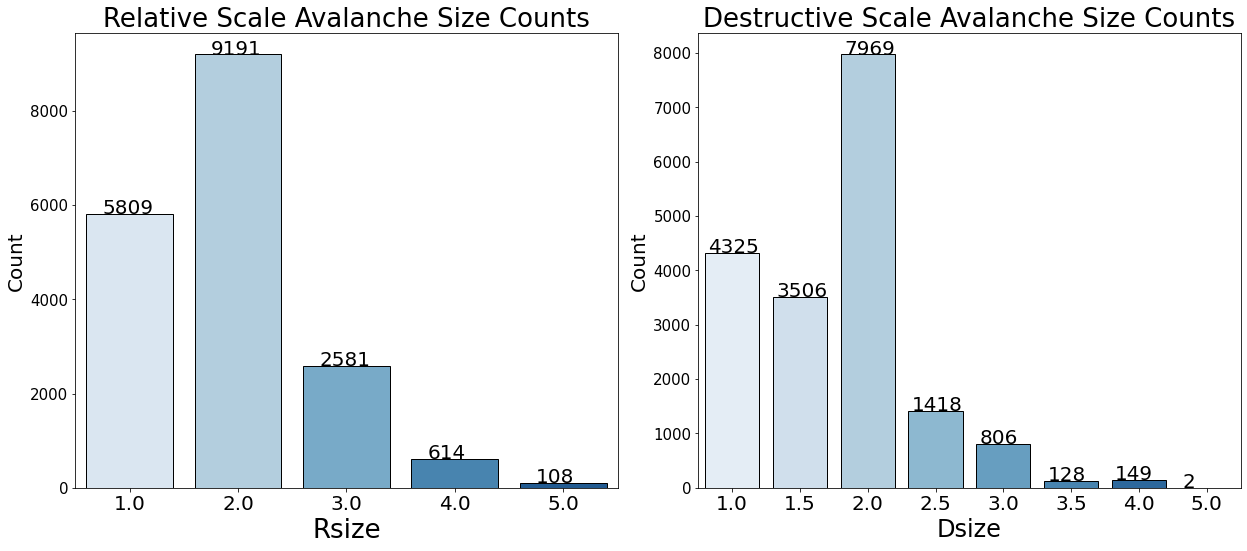

In [3]:
fig, ax = plt.subplots(1, 2)

fig.tight_layout(pad = 5, rect = (0, -0.5, 3, 1.5))
ax1 = sns.countplot(x='Rsize', data = avalanches_df, palette = 'Blues', edgecolor = "Black", ax=ax[0])
ax2 = sns.countplot(x='Dsize', data = avalanches_df, palette='Blues',edgecolor = "Black", ax = ax[1])
ax[0].set_title('Relative Scale Avalanche Size Counts', fontsize = 26)
ax[0].set_xlabel('Rsize', fontsize=26)
ax[0].set_ylabel('Count', fontsize=20)
ax[0].tick_params(axis='x', labelsize=20)
ax[0].tick_params(axis='y', labelsize=15)

ax[1].set_title('Destructive Scale Avalanche Size Counts', fontsize = 26)
ax[1].set_xlabel('Dsize', fontsize=24)
ax[1].set_ylabel('Count', fontsize=20)
ax[1].tick_params(axis='x', labelsize=20)
ax[1].tick_params(axis='y', labelsize=15)

for p in ax1.patches:
   ax1.annotate('{}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+5), fontsize=20)

for p in ax2.patches:
   ax2.annotate('{}'.format(p.get_height()), (p.get_x()+0.05, p.get_height()+5), fontsize=20)

fig.show()

### As we can see, the distribution of relative scale and destructive scale avalanches look approximately the same, a right skewed distribution with 2 being the most common size. 

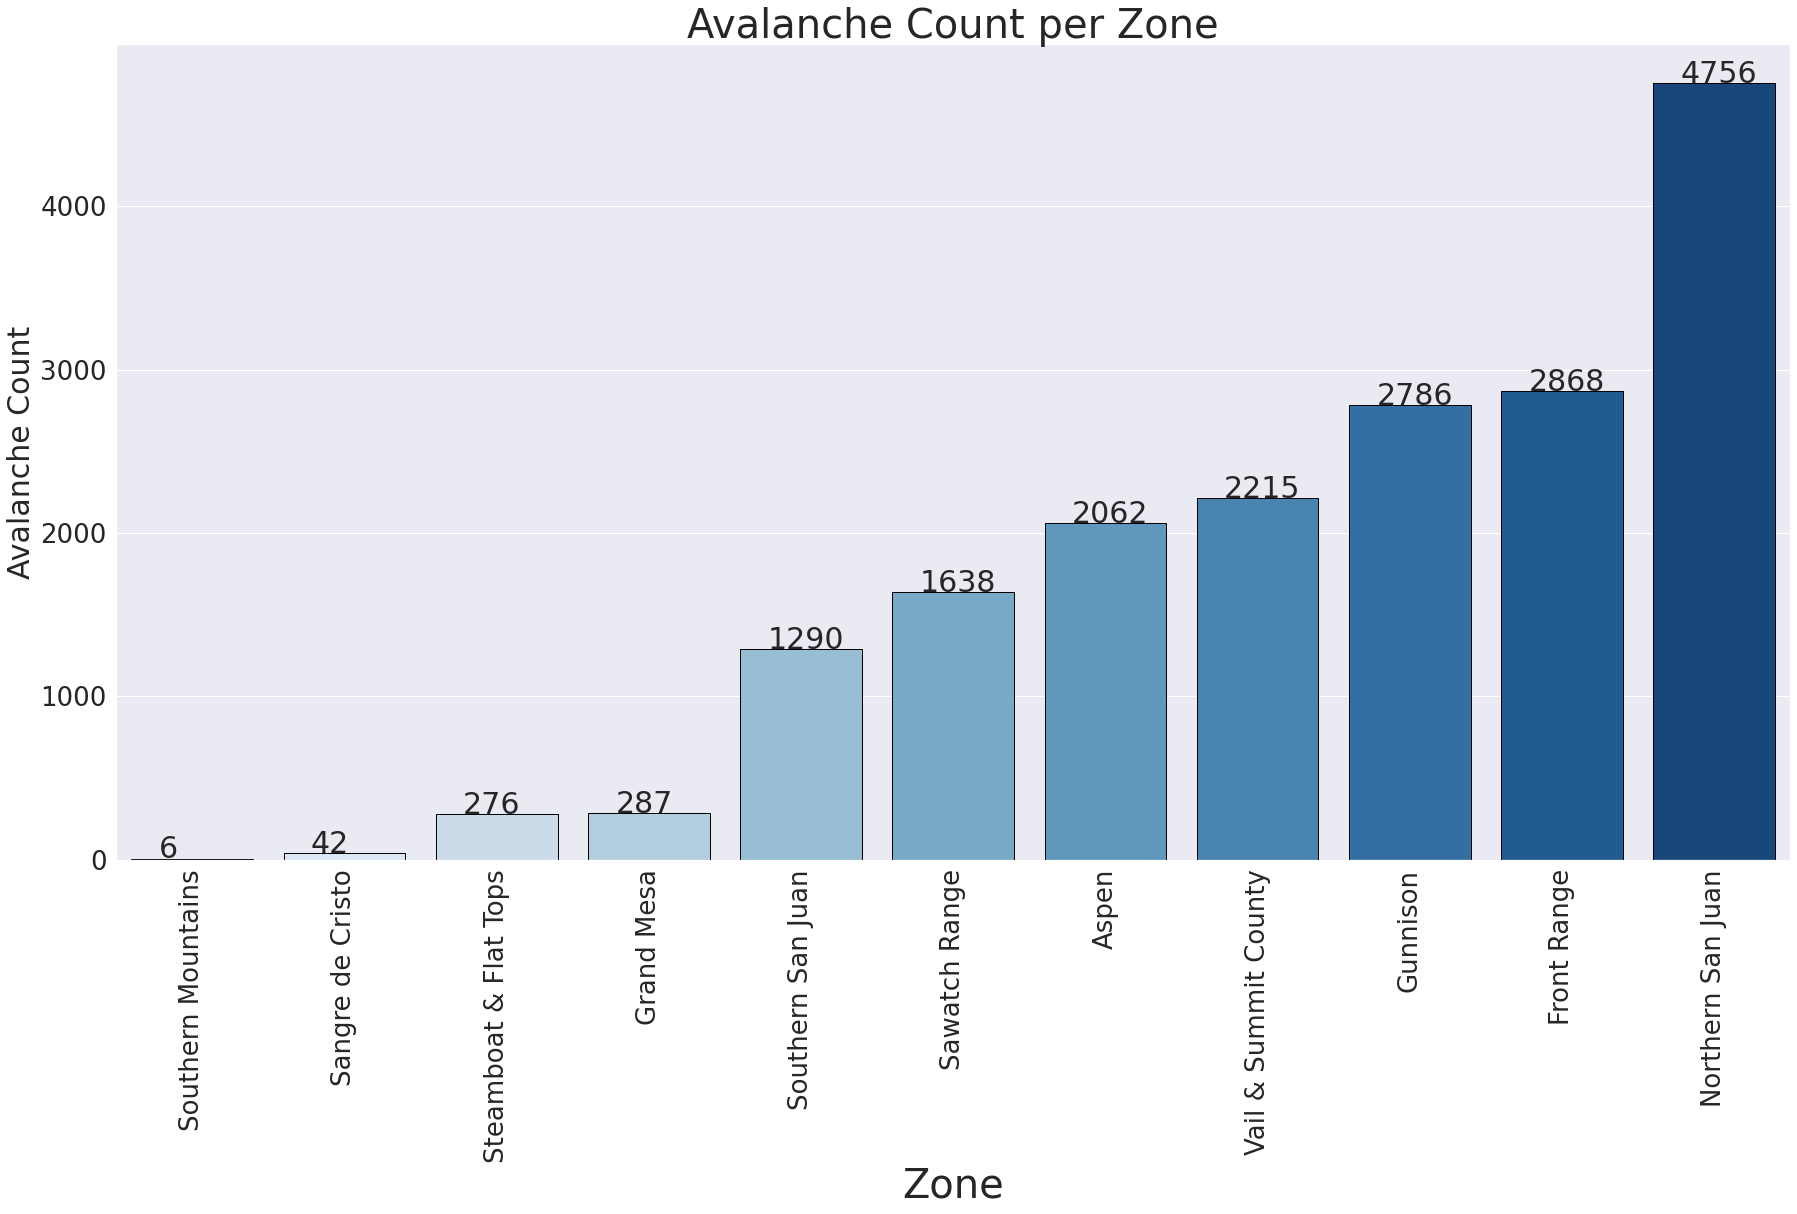

In [4]:
sns.set(rc={'figure.figsize':(30, 15)})
ax = sns.countplot(x='Zone', data = avalanches_df, order = avalanches_df['Zone'].value_counts(ascending=True).index, edgecolor = "Black", palette='Blues')
plt.xticks(rotation = 90, fontsize = 26)
plt.yticks(fontsize=26)
plt.xlabel("Zone", fontsize=40)
plt.ylabel("Avalanche Count", fontsize=30)
plt.title("Avalanche Count per Zone", fontsize = 40)

for p in ax.patches:
   ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.18, p.get_height()+1), fontsize=30)

plt.show()

### Here we have the counts of avalanches per zone, with the Southern Mountains having the fewest avalanches and the Northern San Juans having the greatest number of avalanches. 

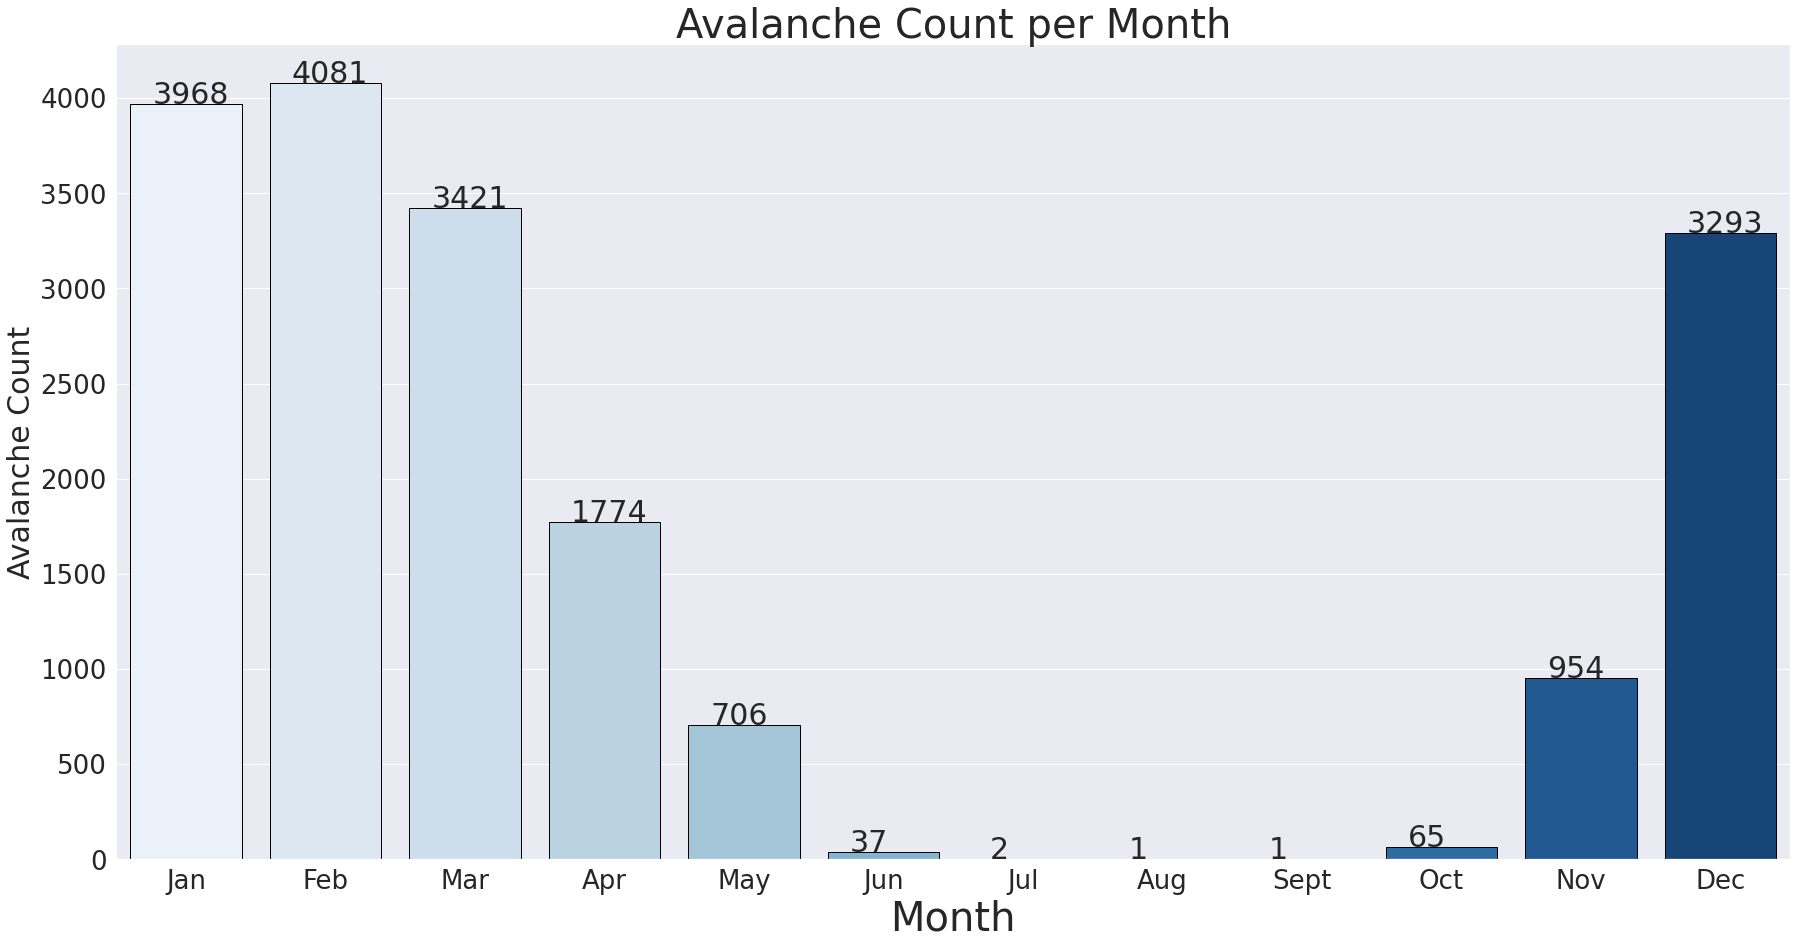

In [5]:
avalanches_df["Month"] = avalanches_df['Date'].apply(lambda x: x.month)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]

sns.set(rc={'figure.figsize':(30, 15)})
ax = sns.countplot(x='Month', data = avalanches_df, edgecolor = "Black", palette='Blues')
plt.xticks(fontsize = 26)
plt.yticks(fontsize=26)
plt.xlabel("Month", fontsize=40)
plt.ylabel("Avalanche Count", fontsize=30)
plt.title("Avalanche Count per Month", fontsize = 40)
ax.set_xticklabels(months)
for p in ax.patches:
   ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.16, p.get_height()+1), fontsize=30)

plt.show()

### Unsurpisingly, the deep winter months have the highest avalanche counts and the summer months have the fewest. 

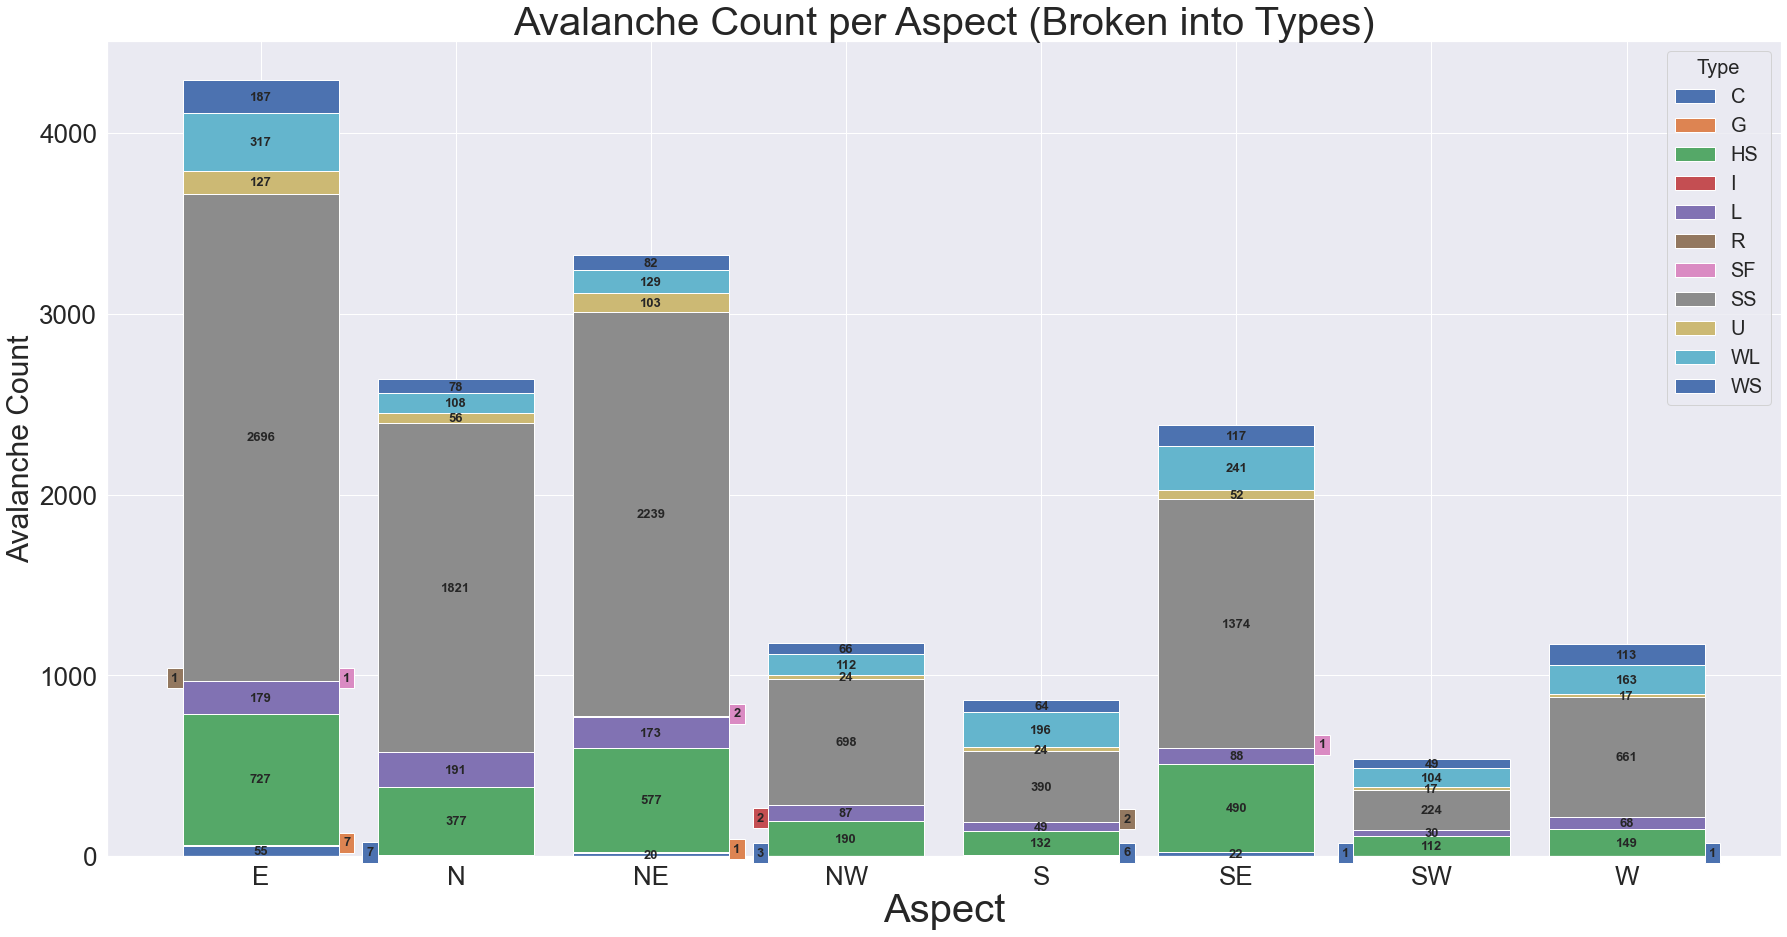

In [118]:
aspect_df = avalanches_df[(avalanches_df["Aspect"] != "U") & (avalanches_df["Aspect"] != "All") & (avalanches_df["Aspect"] != "Unknown")]
aspect_df = aspect_df[aspect_df.Aspect.notna()]
aspect_df.Aspect = aspect_df.Aspect.astype("object")
aspect_df.Aspect = aspect_df.Aspect.astype("category")

aspect_plot = aspect_df.groupby(['Aspect', 'Type']).size().reset_index().pivot(columns = 'Type', index = "Aspect", values = 0)

fig, ax = plt.subplots()

bottom = np.zeros(len(aspect_plot))

for i, col in enumerate(aspect_plot.columns):
   ax.bar(aspect_plot.index, aspect_plot[col], bottom=bottom, label=col)
   bottom += np.array(aspect_plot[col])

y_offset = -20
oldbar = 0
for bar in ax.patches:
   if bar.get_height() < 1:
      continue
   elif bar.get_height() <= 7 and oldbar <= 7:
      ax.text(x = bar.get_x() + bar.get_width() + .04, y = bar.get_height() / 2 + bar.get_y(), s = int(bar.get_height()), ha = 'center', weight = 'bold', size = 13, bbox = dict(facecolor = bar.get_facecolor()))
   elif bar.get_height() <= 7 and oldbar > 7:
      ax.text(x = bar.get_x() - .04, y = bar.get_height() / 2 + bar.get_y(), s = int(bar.get_height()), ha = 'center', weight = 'bold', size = 13, bbox = dict(facecolor = bar.get_facecolor()))
   else:
      ax.text(x = bar.get_x() + bar.get_width() / 2, y = bar.get_height() / 2 + bar.get_y() + y_offset, s = int(bar.get_height()), ha = 'center', weight = 'bold', size = 13)
   oldbar = bar.get_height()


plt.xticks(fontsize = 26)
plt.yticks(fontsize = 26)
plt.xlabel("Aspect", fontsize=40)
plt.ylabel("Avalanche Count", fontsize=30)
plt.title("Avalanche Count per Aspect (Broken into Types)", fontsize = 40)
ax.legend(title = "Type", fontsize = "20", title_fontsize = "20")

plt.show()

### Here we see all mountain aspects with stacked avalanche types. Storm Slab (SS is the most common type on all aspects. The relative distribution of avalanches on each aspect appears even, which is a surprising find considering we expect more warming avalanches (Wet Slab, Wet Loose, etc...) to appear on southern and eastern facing aspects as these see more sun in the Colorado winter. However this appears to not be the case.